### Codeblock 1.1

In [ ]:
def get_links_to_scrape(start_year, end_year):

    import requests
    from bs4 import BeautifulSoup, SoupStrainer

    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    years = [year for year in range(start_year, end_year+1)]
    
    strainer = SoupStrainer('a', class_ = 'SiteMapArticleList-link')
    article_links = []

    for year in years:
        for month in months:
            for day in range(1,32):
                link = f'https://www.cnbc.com/site-map/{year}/{month}/{day}/'

                page = str(requests.get(link).content)
                page = page[str(page).find('body'):]
                soup = BeautifulSoup(page, parse_only = strainer)

                links = soup.find_all('a', class_='SiteMapArticleList-link')
                if links != []:
                    for a_link in links:
                        article_links.append(a_link['href'])

    return article_links

### Codeblock 1.2

In [ ]:

def scrape_cnbc_articles(list_of_links):

    import requests
    from bs4 import BeautifulSoup, SoupStrainer
    import pandas as pd

    df = []
    index = 0
    request = requests.Session()

    for link in list_of_links:
        page = request.get(link)
        index += 1

        if page.status_code == 200:
            try:
                page = str(page.content)
                page = page[page.find('<div id="MainContent"'):]

                soup_link = BeautifulSoup(page)

                title = soup_link.find('h1', class_='ArticleHeader-headline').get_text()
                article = soup_link.find('div', class_='ArticleBody-articleBody').get_text()
                date = f'{link[29:31]}-{link[26:28]}-{link[21:25]}'
                topic = soup_link.find('a', class_='ArticleHeader-eyebrow').get_text()

                df.append([title, topic, date, article, link])

                print(f'({index}/{len(list_of_links)}) : {link}')
            except:
                print(f'({index}/{len(list_of_links)}) : Skipped')
        else:
            print(f'({index}/{len(list_of_links)}) : Skipped')

    return pd.DataFrame(df)

### Codeblock 1.3

In [ ]:
def collect_dataset(datasets_path):

    import pandas as pd

    datasets = [ds for ds in datasets_path if '.csv' in ds]

    frames = []
    for dataset in datasets:
        df = pd.read_csv(dataset, error_bad_lines=False, index_col=False)
        df = df[df.columns[-5:]]
        df.columns = ['Title', 'Topic', 'Date', 'Content', 'Link']
        frames.append(df)

    return pd.concat(frames)


### Codeblock 2.1

In [ ]:
pd.DataFrame(df.Topic.unique()).to_csv('unique_topics.csv')

### Codeblock 2.2

In [ ]:
topic_list = pd.read_csv('final_topic_list.csv', sep = ";")
topic_list_clean = pd.DataFrame.dropna(topic_list)

### Codeblock 2.3

In [ ]:
predetermined = []
index = 0
for topic in df["Topic"]:
    index += 1
    if topic in list(topic_list_clean["Topic"]):
        predetermined.append(topic_list_clean[topic_list_clean["Topic"] == topic]["Predetermined topic"].to_numpy()[0])
    else:
        predetermined.append("Other")
    print(f'{index}')
df['final_topic'] = predetermined

### Codeblock 2.4

In [ ]:
df_labelled = df[df['final_topic'] != 'Other']
df_predict = df[df['final_topic'] == 'Other']

### Codeblock 2.5

In [ ]:
from sklearn.model_selection import train_test_split

r_state = 123

x_train, x_test, y_train, y_test = train_test_split(
    df_labelled['tokens'], df_labelled['final_topic'], test_size=0.25, random_state=r_state)

from gensim import models, corpora
import ast

# At this point we re-imported our data, which is why we run it through the loop below. 
# The loop converts the "tokens" column that previously contained the tokens for each 
# article, but now simply contained a string representation of the list of tokens, into 
# an actual list of tokens again. 
data_processed = x_train.to_numpy()
data_conversion = []
for line in data_processed:
    line = ast.literal_eval(line)
    data_conversion.append(line)
data_processed = data_conversion

dictionary = corpora.Dictionary(data_processed)
corpus = [dictionary.doc2bow(line) for line in data_processed]
tfidf = models.TfidfModel(corpus, smartirs='ntc')
lsa_model = models.LsiModel(tfidf[corpus], id2word=dictionary, num_topics=50)

### Codeblock 2.6

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state = r_state)
xgb_model.fit(x_train, y_train)
xgb_prediction = xgb_model.predict(x_test)
print(classification_report(y_test,xgb_prediction))

### Codeblock 3.1

In [ ]:
def walk_forward_validation(model, epochs, x, y, step_size, train_steps, val_window):
    
    from sklearn.metrics import mean_squared_error
    
    n_records = len(x)
    n_init_train = step_size * train_steps
    train_pred = []
    val_pred = []
    mse_scores = []
    for i in range(n_init_train, n_records, step_size):
      
        train_from = i-n_init_train
        train_to = i
        test_from = i+1
        test_to = i+val_window

        x_train, x_test = x[train_from:train_to], x[test_from:test_to]
        y_train, y_test = y[train_from:train_to], y[test_from:test_to]
        
        print(f'Train from {i-n_init_train} to {i} and validate for {i+1} to {i+val_window}')
        model.fit(x_train, y_train, epochs=epochs, verbose=1)

        y_train_pred = model.predict(x_train)
        for y_train_day in y_train_pred:
            train_pred.append(y_train_day.tolist())
        
        y_pred = model.predict(x_test)
        for y_test_day in y_pred:
            val_pred.append(y_test_day.tolist())

        train_mse = mean_squared_error(y_train,y_train_pred)
        val_mse = mean_squared_error(y_test,y_pred)
        mse_scores.append([train_mse, val_mse])

        print(f'     train: {train_mse} \nvalidation: {val_mse} \n')

    return train_pred, val_pred, mse_scores

train_pred, val_pred, validation_metrics = walk_forward_validation(model = model, epochs = epoch, x = pd.DataFrame(articles_pad[970:]), y = y[970:], step_size = 60, train_steps = 3, val_window = 60)

# Sector returns

In [2]:
import pandas as pd

In [42]:
y_pred_untrain = pd.read_csv('../val_pred_trainable_false.csv').iloc[:,1:]
y_pred_train = pd.read_csv('../val_pred_trainable_true.csv').iloc[:,1:]
y_returns = pd.read_csv('../y_returns_nn.csv').iloc[:,1:]
y_returns = y_returns.iloc[181:180+38*60]

sector_list = ['SP500', 'Tech', 'Energy', 'Financials', 'Healthcare', 'Industrials', 'Consumer Discretionary', 'Utilities', 'Materials', 'Consumer Staples', 'Telecom', 'Real Estate']

In [43]:
correlations = pd.DataFrame([y_returns.iloc[column].corr(y_pred_train.iloc[column]) for column in range(1,13)], columns = ['Actual/Trained'])
correlations.index = sector_list
correlations

,Actual/Trained
SP500,0.042950
Tech,-0.861722
Energy,-0.220091
Financials,-0.248198
Healthcare,0.133296
Industrials,0.458688
Consumer Discretionary,-0.019690
Utilities,0.660723
Materials,-0.061305
Consumer Staples,0.309094


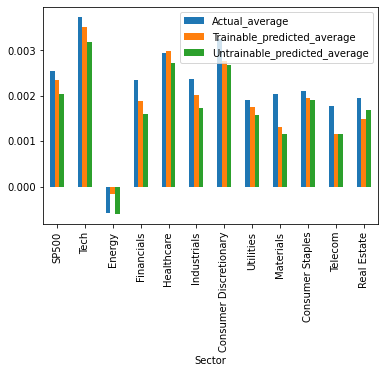

In [44]:
average_sector_returns = pd.concat([pd.DataFrame(y_returns.mean()-1),pd.DataFrame(y_pred_train.mean()-1),pd.DataFrame(y_pred_untrain.mean()-1)], axis=1)
average_sector_returns.columns = ['Actual_average', 'Trainable_predicted_average', 'Untrainable_predicted_average']
sector_list = ['SP500', 'Tech', 'Energy', 'Financials', 'Healthcare', 'Industrials', 'Consumer Discretionary', 'Utilities', 'Materials', 'Consumer Staples', 'Telecom', 'Real Estate']
average_sector_returns['Sector'] = sector_list

import matplotlib.pyplot as plt

average_sector_returns.plot(x="Sector", y=['Actual_average', 'Trainable_predicted_average', 'Untrainable_predicted_average'], kind="bar")
plt.show()

In [24]:
y_pred_train.mean()-1

0     0.002344
1     0.003507
2    -0.000155
3     0.001873
4     0.002992
5     0.002024
6     0.002766
7     0.001742
8     0.001318
9     0.001960
10    0.001168
11    0.001479
dtype: float64